In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("/drive/MyDrive/ml/vtb/train_data.csv")
df.shape

(20952, 3)

In [4]:
df.label_group.unique().shape

(6608,)

In [5]:
tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
df['matches'] = df['label_group'].map(tmp)
df['matches'] = df['matches'].apply(lambda x: ' '.join(x))

нашей метрикой будет построчный f1

In [6]:
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

в качестве бейзлайна сопоставим себя в группу только с самим собой и каким нибудь еще одним случайным товаром

In [7]:
df['prediction'] = df['posting_id'] + ' ' + 'train_129225211'

In [8]:
f1_score(df['matches'], df['prediction']).mean()

0.35675992543848534

твоя цель улучшить эту метрику, можешь пользоваться любыми методами

но учитывай что на проде данных много и методы должны адаптироваться на большие данные

# Протестируем разные подходы на первой сотне:

In [9]:
df = df.head(100)

### 1. Dummy string comparison

In [10]:
!pip install fuzzywuzzy[speedup]

     |████████████████████████████████| 50 kB 3.0 MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149849 sha256=a2c7d1768185a7cfff19de68e695fa755bce3c108f5dacf4d321dd46f3b7ed35
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-levenshtein


In [11]:
texts = list(df['title'])

In [12]:
import re

def cleaner(text):
    text = re.sub('[^a-z0-9 ]', ' ', str(text).lower())
    text = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", text).strip()
    text = re.sub(r" +", " ", text.strip())
    return text

In [13]:
from tqdm import tqdm

In [14]:
texts = [cleaner(text) for text in tqdm(texts)]

100%|██████████| 100/100 [00:00<00:00, 26574.82it/s]


In [15]:
df['text'] = texts

In [16]:
from fuzzywuzzy import fuzz

In [17]:
predict_list = []
for text in tqdm(list(df['text'])):
    predict = ''
    for j, t in enumerate(list(df['text'])):
        if fuzz.partial_ratio(text, t) >= 75:
            predict += list(df['posting_id'])[j] + ' '
    predict.strip()
    predict_list.append(predict)

100%|██████████| 100/100 [00:00<00:00, 108.40it/s]


In [18]:
match_list = list(df['matches'])[:len(predict_list)]

In [19]:
f1_score(pd.Series(match_list), pd.Series(predict_list)).mean()

0.710964434346455

### 2. Pretrained embeddings

In [20]:
!pip install transformers sentencepiece

     |████████████████████████████████| 4.0 MB 4.7 MB/s 
     |████████████████████████████████| 1.2 MB 51.9 MB/s 
     |████████████████████████████████| 6.6 MB 46.9 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 65.3 MB/s 
     |████████████████████████████████| 895 kB 63.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [21]:
import torch
from transformers import AutoTokenizer, AutoModel
from scipy.spatial import distance

In [22]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
def get_embed(texts):
    with torch.no_grad():
        encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=64, return_tensors='pt')
        output = model(**encoded_input).pooler_output
    return output.numpy()

In [24]:
texts = list(df['title'])
embeds = get_embed(texts)

In [25]:
df['embed'] = embeds.tolist()

In [26]:
threshold = 6.25
predict_list = []
for embed in tqdm(list(df['embed'])):
    predict = ''
    for j, e in enumerate(list(df['embed'])):
        if distance.euclidean(embed, e) < threshold:
            predict += list(df['posting_id'])[j] + ' '
    predict.strip()
    predict_list.append(predict)

100%|██████████| 100/100 [00:01<00:00, 64.68it/s]


In [27]:
match_list = list(df['matches'])

In [28]:
df['predicted'] = predict_list

In [29]:
f1_score(pd.Series(match_list), pd.Series(predict_list)).mean()

0.7518936033312208

###3. Pretrained embeddings + metric learning

In [30]:
!pip install metric-learn

     |████████████████████████████████| 64 kB 2.1 MB/s 


In [31]:
from metric_learn import SCML

In [32]:
# random triplet generator: anchor-positive-negative

In [33]:
label_group_list = list(set(df['label_group']))

In [34]:
label_group_list = [group for group in label_group_list if len(df[df['label_group'] == group]) > 1]

In [35]:
import random

In [36]:
triplet_list = []
for i in range(1000):
    group_pos, group_neg = random.sample(label_group_list, 2)
    pos_embeds = random.sample(list(df[df['label_group'] == group_pos]['embed']), 2)
    neg_embed = random.sample(list(df[df['label_group'] == group_neg]['embed']), 1)
    triplet_list.append(pos_embeds + neg_embed)

In [37]:
triplets = np.array(triplet_list)

In [38]:
scml = SCML(random_state=42)

In [39]:
scml.fit(triplets)

/usr/local/lib/python3.7/dist-packages/metric_learn/scml.py:236: UserWarning: As no value for `n_basis` was selected, the number of basis will be set to n_basis= 61440
  'basis will be set to n_basis= %d' % n_basis)


SCML(random_state=42)

In [40]:
trans_embeds = scml.transform(list(df['embed']))

In [41]:
df['trans'] = trans_embeds.tolist()

In [42]:
metric = scml.get_metric()

In [43]:
score_list = []
for i in range(10, 130):
    threshold = 100 * i
    predict_list = []
    for embed in tqdm(list(df['trans'])):
        predict = ''
        for j, e in enumerate(list(df['trans'])):
            if metric(embed, e) < threshold:
                predict += list(df['posting_id'])[j] + ' '
        predict.strip()
        predict_list.append(predict)

    match_list = list(df['matches'])
    df['predicted'] = predict_list
    score = f1_score(pd.Series(match_list), pd.Series(predict_list)).mean()
    score_list.append(score)
    print(threshold, score)

100%|██████████| 100/100 [00:06<00:00, 15.31it/s]


1000 0.4235238095238097


100%|██████████| 100/100 [00:04<00:00, 20.14it/s]


1100 0.4235238095238097


100%|██████████| 100/100 [00:04<00:00, 20.85it/s]


1200 0.42533333333333345


100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


1300 0.42533333333333345


100%|██████████| 100/100 [00:04<00:00, 20.85it/s]


1400 0.4270606060606062


100%|██████████| 100/100 [00:07<00:00, 13.71it/s]


1500 0.4270606060606062


100%|██████████| 100/100 [00:05<00:00, 19.65it/s]


1600 0.4270606060606062


100%|██████████| 100/100 [00:04<00:00, 20.27it/s]


1700 0.4270606060606062


100%|██████████| 100/100 [00:04<00:00, 20.61it/s]


1800 0.4270606060606062


100%|██████████| 100/100 [00:04<00:00, 20.71it/s]


1900 0.42870562770562787


100%|██████████| 100/100 [00:04<00:00, 20.69it/s]


2000 0.42870562770562787


100%|██████████| 100/100 [00:04<00:00, 20.70it/s]


2100 0.42870562770562787


100%|██████████| 100/100 [00:04<00:00, 20.75it/s]


2200 0.42870562770562787


100%|██████████| 100/100 [00:04<00:00, 21.28it/s]


2300 0.42870562770562787


100%|██████████| 100/100 [00:04<00:00, 20.87it/s]


2400 0.42870562770562787


100%|██████████| 100/100 [00:04<00:00, 20.81it/s]


2500 0.42870562770562787


100%|██████████| 100/100 [00:05<00:00, 18.26it/s]


2600 0.42870562770562787


100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


2700 0.42870562770562787


100%|██████████| 100/100 [00:05<00:00, 16.86it/s]


2800 0.4320779220779222


100%|██████████| 100/100 [00:04<00:00, 20.86it/s]


2900 0.4320779220779222


100%|██████████| 100/100 [00:04<00:00, 20.32it/s]


3000 0.4320779220779222


100%|██████████| 100/100 [00:04<00:00, 20.52it/s]


3100 0.44006907585168464


100%|██████████| 100/100 [00:05<00:00, 19.34it/s]


3200 0.44006907585168464


100%|██████████| 100/100 [00:04<00:00, 20.18it/s]


3300 0.44006907585168464


100%|██████████| 100/100 [00:04<00:00, 20.23it/s]


3400 0.44006907585168464


100%|██████████| 100/100 [00:05<00:00, 20.00it/s]


3500 0.44483098061358944


100%|██████████| 100/100 [00:04<00:00, 20.10it/s]


3600 0.44483098061358944


100%|██████████| 100/100 [00:04<00:00, 20.01it/s]


3700 0.44483098061358944


100%|██████████| 100/100 [00:05<00:00, 19.53it/s]


3800 0.44483098061358944


100%|██████████| 100/100 [00:04<00:00, 20.33it/s]


3900 0.4529996235648411


100%|██████████| 100/100 [00:04<00:00, 20.27it/s]


4000 0.4529996235648411


100%|██████████| 100/100 [00:04<00:00, 20.02it/s]


4100 0.4529996235648411


100%|██████████| 100/100 [00:04<00:00, 20.14it/s]


4200 0.4529996235648411


100%|██████████| 100/100 [00:05<00:00, 19.89it/s]


4300 0.4529996235648411


100%|██████████| 100/100 [00:04<00:00, 20.92it/s]


4400 0.45480914737436495


100%|██████████| 100/100 [00:05<00:00, 19.82it/s]


4500 0.45480914737436495


100%|██████████| 100/100 [00:04<00:00, 20.51it/s]


4600 0.45480914737436495


100%|██████████| 100/100 [00:04<00:00, 20.43it/s]


4700 0.45480914737436495


100%|██████████| 100/100 [00:04<00:00, 20.11it/s]


4800 0.4589758140410315


100%|██████████| 100/100 [00:04<00:00, 20.20it/s]


4900 0.46056898174289485


100%|██████████| 100/100 [00:05<00:00, 19.79it/s]


5000 0.4695689817428949


100%|██████████| 100/100 [00:05<00:00, 19.66it/s]


5100 0.4695689817428949


100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


5200 0.4731404103143235


100%|██████████| 100/100 [00:04<00:00, 20.25it/s]


5300 0.47591818809210124


100%|██████████| 100/100 [00:04<00:00, 20.68it/s]


5400 0.4790927912667044


100%|██████████| 100/100 [00:04<00:00, 20.38it/s]


5500 0.48695507873768756


100%|██████████| 100/100 [00:04<00:00, 20.84it/s]


5600 0.48695507873768756


100%|██████████| 100/100 [00:04<00:00, 20.36it/s]


5700 0.48945507873768757


100%|██████████| 100/100 [00:04<00:00, 20.28it/s]


5800 0.49240538929669375


100%|██████████| 100/100 [00:04<00:00, 21.09it/s]


5900 0.4984421858334903


100%|██████████| 100/100 [00:04<00:00, 20.49it/s]


6000 0.4984421858334903


100%|██████████| 100/100 [00:04<00:00, 20.47it/s]


6100 0.5092269904009037


100%|██████████| 100/100 [00:04<00:00, 20.59it/s]


6200 0.5165487295313383


100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


6300 0.5232153961980051


100%|██████████| 100/100 [00:05<00:00, 19.43it/s]


6400 0.5258101565101566


100%|██████████| 100/100 [00:04<00:00, 20.35it/s]


6500 0.5258101565101566


100%|██████████| 100/100 [00:04<00:00, 20.08it/s]


6600 0.5286503221416265


100%|██████████| 100/100 [00:04<00:00, 20.16it/s]


6700 0.5419720612720614


100%|██████████| 100/100 [00:05<00:00, 19.79it/s]


6800 0.5457203110674294


100%|██████████| 100/100 [00:05<00:00, 19.08it/s]


6900 0.5457203110674294


100%|██████████| 100/100 [00:05<00:00, 19.50it/s]


7000 0.5502240147711331


100%|██████████| 100/100 [00:04<00:00, 20.70it/s]


7100 0.553843343590462


100%|██████████| 100/100 [00:05<00:00, 19.96it/s]


7200 0.553843343590462


100%|██████████| 100/100 [00:04<00:00, 20.45it/s]


7300 0.5563149259533486


100%|██████████| 100/100 [00:04<00:00, 20.28it/s]


7400 0.5650474896859125


100%|██████████| 100/100 [00:04<00:00, 20.31it/s]


7500 0.5662772060243245


100%|██████████| 100/100 [00:04<00:00, 20.28it/s]


7600 0.5690060713618854


100%|██████████| 100/100 [00:04<00:00, 20.44it/s]


7700 0.573339725242016


100%|██████████| 100/100 [00:05<00:00, 19.86it/s]


7800 0.5766966384437567


100%|██████████| 100/100 [00:04<00:00, 20.45it/s]


7900 0.5885717154878743


100%|██████████| 100/100 [00:04<00:00, 20.24it/s]


8000 0.595510956004701


100%|██████████| 100/100 [00:04<00:00, 20.22it/s]


8100 0.6045225170351526


100%|██████████| 100/100 [00:04<00:00, 20.44it/s]


8200 0.6347952774803268


100%|██████████| 100/100 [00:04<00:00, 20.33it/s]


8300 0.6347952774803268


100%|██████████| 100/100 [00:04<00:00, 20.30it/s]


8400 0.6441966677104156


100%|██████████| 100/100 [00:04<00:00, 20.27it/s]


8500 0.6550636107784712


100%|██████████| 100/100 [00:04<00:00, 20.63it/s]


8600 0.6601319352188887


100%|██████████| 100/100 [00:04<00:00, 20.51it/s]


8700 0.6642062384518874


100%|██████████| 100/100 [00:04<00:00, 20.33it/s]


8800 0.665902667023316


100%|██████████| 100/100 [00:04<00:00, 20.16it/s]


8900 0.6786239849211044


100%|██████████| 100/100 [00:05<00:00, 19.28it/s]


9000 0.6907740241292082


100%|██████████| 100/100 [00:05<00:00, 19.51it/s]


9100 0.6947740241292081


100%|██████████| 100/100 [00:04<00:00, 20.20it/s]


9200 0.702348774959773


100%|██████████| 100/100 [00:04<00:00, 20.18it/s]


9300 0.7189695708305688


100%|██████████| 100/100 [00:05<00:00, 19.92it/s]


9400 0.7215851970303752


100%|██████████| 100/100 [00:04<00:00, 20.06it/s]


9500 0.7316581091757012


100%|██████████| 100/100 [00:05<00:00, 19.67it/s]


9600 0.7403533834387518


100%|██████████| 100/100 [00:04<00:00, 20.16it/s]


9700 0.7468255978604817


100%|██████████| 100/100 [00:04<00:00, 20.27it/s]


9800 0.7522412271033764


100%|██████████| 100/100 [00:04<00:00, 20.57it/s]


9900 0.7577102234352515


100%|██████████| 100/100 [00:04<00:00, 20.41it/s]


10000 0.7641950552257368


100%|██████████| 100/100 [00:04<00:00, 20.68it/s]


10100 0.7674655680477654


100%|██████████| 100/100 [00:05<00:00, 19.77it/s]


10200 0.7691259297081272


100%|██████████| 100/100 [00:05<00:00, 19.70it/s]


10300 0.7696989695351748


100%|██████████| 100/100 [00:04<00:00, 20.60it/s]


10400 0.7696243697163889


100%|██████████| 100/100 [00:04<00:00, 20.20it/s]


10500 0.7762299500015437


100%|██████████| 100/100 [00:04<00:00, 20.47it/s]


10600 0.7900392479171282


100%|██████████| 100/100 [00:05<00:00, 19.81it/s]


10700 0.7925658319664799


100%|██████████| 100/100 [00:04<00:00, 20.20it/s]


10800 0.8058388878145357


100%|██████████| 100/100 [00:04<00:00, 20.04it/s]


10900 0.8089208201703525


100%|██████████| 100/100 [00:05<00:00, 19.80it/s]


11000 0.8165821448376418


100%|██████████| 100/100 [00:05<00:00, 19.93it/s]


11100 0.8125693781479759


100%|██████████| 100/100 [00:04<00:00, 20.23it/s]


11200 0.8050298789799348


100%|██████████| 100/100 [00:04<00:00, 20.01it/s]


11300 0.7992973133415612


100%|██████████| 100/100 [00:04<00:00, 20.18it/s]


11400 0.7984494839970574


100%|██████████| 100/100 [00:04<00:00, 20.08it/s]


11500 0.7982137042406896


100%|██████████| 100/100 [00:05<00:00, 19.94it/s]


11600 0.7937586528970862


100%|██████████| 100/100 [00:04<00:00, 20.05it/s]


11700 0.8031147282297013


100%|██████████| 100/100 [00:05<00:00, 19.62it/s]


11800 0.7944319577704604


100%|██████████| 100/100 [00:04<00:00, 20.28it/s]


11900 0.7864403494533971


100%|██████████| 100/100 [00:05<00:00, 19.44it/s]


12000 0.7733430570027161


100%|██████████| 100/100 [00:05<00:00, 19.98it/s]


12100 0.7581587337134904


100%|██████████| 100/100 [00:04<00:00, 20.33it/s]


12200 0.7485566850549997


100%|██████████| 100/100 [00:04<00:00, 20.15it/s]


12300 0.7390415270425171


100%|██████████| 100/100 [00:05<00:00, 19.86it/s]


12400 0.7401517294467423


100%|██████████| 100/100 [00:04<00:00, 20.24it/s]


12500 0.7288836568412198


100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


12600 0.7171101369171565


100%|██████████| 100/100 [00:05<00:00, 19.92it/s]


12700 0.7081516360179461


100%|██████████| 100/100 [00:04<00:00, 20.08it/s]


12800 0.6932875609651292


100%|██████████| 100/100 [00:05<00:00, 19.99it/s]

12900 0.6820872580929263


In [44]:
max(score_list)

0.8165821448376418

### 4. Embediings + triplet loss: https://github.com/KevinMusgrave/pytorch-metric-learning/

In [45]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     |████████████████████████████████| 109 kB 5.4 MB/s 
     |████████████████████████████████| 85.5 MB 76 kB/s 


#### 4.1 LaBSE + PML

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [47]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [48]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        out = self.fc2(x)
        return out

In [49]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    def __init__(self, embeds, labels):
        self.embeds = embeds
        self.labels = labels

    def __len__(self):
        return len(self.embeds)

    def __getitem__(self, idx):
        embed = self.embeds[idx]
        label = self.labels[idx]
        return embed, label

In [50]:
labels = np.array(list(df['label_group']))

In [51]:
dataset = CustomDataset(embeds, labels)

In [52]:
loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [54]:
model = NeuralNetwork()

In [55]:
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [56]:
num_epochs = 1000

In [57]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)

In [58]:
model.to(device)

NeuralNetwork(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
)

In [59]:
from tqdm import tqdm

In [60]:
from scipy.spatial import distance

In [61]:
# тестовый набор
anchor = embeds[0]
positive = embeds[1]
negative = embeds[2]

In [62]:
print(distance.cosine(anchor, positive),
    distance.cosine(anchor, negative))

0.36886048316955566 0.9417772814631462


In [63]:
model.train()
for epoch in range(1000):
    for data, labels in loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
    # test model
    anchor_test = model(torch.tensor(anchor).to(device)).detach().numpy()
    positive_test = model(torch.tensor(positive).to(device)).detach().numpy()
    negative_test = model(torch.tensor(negative).to(device)).detach().numpy()
    if epoch % 100 == 0:
        print(distance.cosine(anchor_test, positive_test),
            distance.cosine(anchor_test, negative_test))

0.030578017234802246 0.11699551343917847
0.06932127475738525 0.7514108270406723
0.0391768217086792 1.1150054261088371
0.03914344310760498 1.1146886125206947
0.03914344310760498 1.1146886050701141
0.03914344310760498 1.1146886050701141
0.03914344310760498 1.1146886050701141
0.03914344310760498 1.1146886050701141
0.03914344310760498 1.1146886050701141
0.03914344310760498 1.1146886050701141


In [64]:
anchor_test = model(torch.tensor(anchor).to(device)).detach().numpy()
positive_test = model(torch.tensor(positive).to(device)).detach().numpy()
negative_test = model(torch.tensor(negative).to(device)).detach().numpy()

In [65]:
print(distance.cosine(anchor_test, positive_test),
        distance.cosine(anchor_test, negative_test))

0.03914344310760498 1.1146886050701141


In [66]:
embeds_transormed = model(torch.tensor(embeds))

In [67]:
df['transformed'] = list(embeds_transormed.detach().numpy())

In [68]:
score_list = []
for i in range(20):
    threshold = 0.05 * i
    predict_list = []
    for embed in tqdm(list(df['transformed'])):
        predict = ''
        for j, e in enumerate(list(df['transformed'])):
            if distance.cosine(embed, e) < threshold:
                predict += list(df['posting_id'])[j] + ' '
        predict.strip()
        predict_list.append(predict)

    match_list = list(df['matches'])
    df['predicted'] = predict_list
    score = f1_score(pd.Series(match_list), pd.Series(predict_list)).mean()
    score_list.append(score)
    print(threshold, score)

100%|██████████| 100/100 [00:00<00:00, 175.26it/s]


0.0 0.0


100%|██████████| 100/100 [00:00<00:00, 126.77it/s]


0.05 0.8629400815427785


100%|██████████| 100/100 [00:00<00:00, 163.79it/s]


0.1 0.923062917474682


100%|██████████| 100/100 [00:00<00:00, 162.38it/s]


0.15000000000000002 0.9365384615384614


100%|██████████| 100/100 [00:00<00:00, 158.28it/s]


0.2 0.9365384615384614


100%|██████████| 100/100 [00:00<00:00, 163.82it/s]


0.25 0.9325384615384614


100%|██████████| 100/100 [00:00<00:00, 163.79it/s]


0.30000000000000004 0.9226654456654455


100%|██████████| 100/100 [00:00<00:00, 124.24it/s]


0.35000000000000003 0.8871386206386205


100%|██████████| 100/100 [00:00<00:00, 163.43it/s]


0.4 0.8181541633130874


100%|██████████| 100/100 [00:00<00:00, 102.07it/s]


0.45 0.7278047782574752


100%|██████████| 100/100 [00:01<00:00, 80.28it/s]


0.5 0.6381813418189627


100%|██████████| 100/100 [00:02<00:00, 47.21it/s]


0.55 0.5520636004368231


100%|██████████| 100/100 [00:02<00:00, 45.23it/s]


0.6000000000000001 0.46663961477374644


100%|██████████| 100/100 [00:02<00:00, 34.57it/s]


0.65 0.4092709389908588


100%|██████████| 100/100 [00:02<00:00, 37.07it/s]


0.7000000000000001 0.3539520797182012


100%|██████████| 100/100 [00:02<00:00, 35.75it/s]


0.75 0.3145094451207137


100%|██████████| 100/100 [00:02<00:00, 37.17it/s]


0.8 0.28893385364570845


100%|██████████| 100/100 [00:02<00:00, 35.83it/s]


0.8500000000000001 0.2636159957591288


100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


0.9 0.24385329558597


100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


0.9500000000000001 0.22750519142532888


In [69]:
max(score_list)

0.9365384615384614

###5. Main model

### Get data

In [70]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [71]:
import numpy as np
import pandas as pd

In [72]:
df = pd.read_csv("/drive/MyDrive/ml/vtb/train_data.csv")

In [73]:
tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
df['matches'] = df['label_group'].map(tmp)
df['matches'] = df['matches'].apply(lambda x: ' '.join(x))

In [74]:
texts = list(df['title'])

In [75]:
import re

def cleaner(text):
    text = re.sub('[^a-z0-9 ]', ' ', str(text).lower())
    text = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", text).strip()
    text = re.sub(r" +", " ", text.strip())
    return text

In [76]:
from tqdm import tqdm

In [77]:
texts = [cleaner(text) for text in tqdm(texts)]

100%|██████████| 20952/20952 [00:01<00:00, 18545.23it/s]


In [78]:
df['text'] = texts

In [79]:
with open('texts.txt', 'w') as f:
    for text in texts:
        f.write("%s\n" % text)

### Tokenizer

In [80]:
from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = ByteLevelBPETokenizer()
tokenizer.pre_tokenizer = Whitespace()

tokenizer.enable_padding(pad_id=0, pad_token='<pad>')

tokenizer.train(
    files=['/content/texts.txt'],
    vocab_size=3_000,
    min_frequency=2,
    special_tokens=['<pad>', '<unk>']
    )

In [81]:
tokens_list = [tokenizer.encode(text).ids for text in texts]

In [83]:
df['tokens'] = tokens_list

In [ ]:
len_list = [len(tokens) for tokens in list(df['tokens'])]

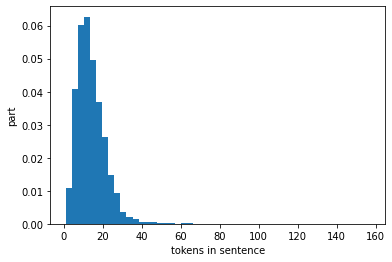

In [85]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(len_list, density=True, bins=50)
plt.ylabel('part')
plt.xlabel('tokens in sentence');

In [86]:
max_len = 32

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    def __init__(self, tokens, labels, max_len):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        label = self.labels[idx]
        label = torch.tensor(label)
        tokens = self.tokens[idx]
        out = torch.zeros(max_len, dtype=torch.long)
        out[:len(tokens)] = torch.tensor(tokens, dtype=torch.long)[:max_len]
        return out, label

In [88]:
labels = np.array(list(df['label_group']))

In [89]:
dataset = CustomDataset(tokens_list, labels, max_len)

#### Model

In [90]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_dim=256, vocab_size=3000, embedding_dim=300):
        super(NeuralNetwork, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(0.4)        
        self.out_layer = nn.Linear(hidden_dim * 2, 256)

    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeddings = self.embedding_layer(inputs)
        output, (final_hidden_state, final_cell_state) = self.lstm_layer(embeddings)
        final_hidden_state = final_hidden_state.transpose(0, 1)
        final_hidden_state = final_hidden_state.reshape(batch_size, -1)
        text_hidden = self.dropout_layer(final_hidden_state)
        out = self.out_layer(text_hidden)
        return out

#### Helpers

In [91]:
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [93]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

#### PML

In [94]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [95]:
model = NeuralNetwork(hidden_dim=256, vocab_size=3000, embedding_dim=300)

In [96]:
num_epochs = 2

In [97]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)

In [98]:
model.to(device)

NeuralNetwork(
  (embedding_layer): Embedding(3000, 300)
  (lstm_layer): LSTM(300, 256, batch_first=True, bidirectional=True)
  (dropout_layer): Dropout(p=0.4, inplace=False)
  (out_layer): Linear(in_features=512, out_features=256, bias=True)
)

In [99]:
from tqdm import tqdm

In [100]:
from scipy.spatial import distance

In [101]:
model.train()
for epoch in range(num_epochs):
    for inputs, labels in tqdm(loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()

100%|██████████| 82/82 [01:49<00:00,  1.33s/it]


In [102]:
model.eval()

NeuralNetwork(
  (embedding_layer): Embedding(3000, 300)
  (lstm_layer): LSTM(300, 256, batch_first=True, bidirectional=True)
  (dropout_layer): Dropout(p=0.4, inplace=False)
  (out_layer): Linear(in_features=512, out_features=256, bias=True)
)

In [103]:
embeddings = []
with torch.no_grad():
    for inputs, labels in tqdm(dataset):
        embedding = model(inputs.reshape(1,-1))[0]
        embeddings.append(embedding)

100%|██████████| 20952/20952 [02:08<00:00, 162.97it/s]


In [104]:
df['embedding'] = embeddings

In [105]:
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

In [106]:
df_test = df.head(100)

score_list = []
for i in range(20):
    threshold = 0.05 * i
    predict_list = []
    for embed in tqdm(list(df_test['embedding'])):
        predict = ''
        for j, e in enumerate(list(df_test['embedding'])):
            if distance.cosine(embed, e) < threshold:
                predict += list(df_test['posting_id'])[j] + ' '
        predict.strip()
        predict_list.append(predict)

    match_list = list(df_test['matches'])
    df_test['predicted'] = predict_list
    score = f1_score(pd.Series(match_list), pd.Series(predict_list)).mean()
    score_list.append(score)
    print(threshold, score)

100%|██████████| 100/100 [00:00<00:00, 143.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


0.0 0.0


100%|██████████| 100/100 [00:00<00:00, 143.52it/s]


0.05 0.6405774814332955


100%|██████████| 100/100 [00:00<00:00, 142.17it/s]


0.1 0.6830255444813583


100%|██████████| 100/100 [00:00<00:00, 143.10it/s]


0.15000000000000002 0.7138243341150292


100%|██████████| 100/100 [00:00<00:00, 139.02it/s]


0.2 0.4603861337069667


100%|██████████| 100/100 [00:00<00:00, 117.36it/s]


0.25 0.18037147962570527


100%|██████████| 100/100 [00:00<00:00, 107.63it/s]


0.30000000000000004 0.13588158579609455


100%|██████████| 100/100 [00:00<00:00, 106.56it/s]


0.35000000000000003 0.1321456617908932


100%|██████████| 100/100 [00:00<00:00, 106.27it/s]


0.4 0.1262936210655737


100%|██████████| 100/100 [00:00<00:00, 106.29it/s]


0.45 0.12236582144137607


100%|██████████| 100/100 [00:01<00:00, 99.56it/s]


0.5 0.12151744476095529


100%|██████████| 100/100 [00:00<00:00, 103.32it/s]


0.55 0.12127658840750798


100%|██████████| 100/100 [00:00<00:00, 107.84it/s]


0.6000000000000001 0.12127658840750798


100%|██████████| 100/100 [00:00<00:00, 106.03it/s]


0.65 0.12024952673538153


100%|██████████| 100/100 [00:01<00:00, 99.52it/s]


0.7000000000000001 0.12024952673538153


100%|██████████| 100/100 [00:00<00:00, 108.00it/s]


0.75 0.12024952673538153


100%|██████████| 100/100 [00:00<00:00, 103.02it/s]


0.8 0.1190525462482714


100%|██████████| 100/100 [00:00<00:00, 106.80it/s]


0.8500000000000001 0.1190525462482714


100%|██████████| 100/100 [00:00<00:00, 108.05it/s]


0.9 0.11704491521304294


100%|██████████| 100/100 [00:00<00:00, 106.07it/s]

0.9500000000000001 0.1158496214103938


In [107]:
max(score_list)

0.7138243341150292

### По результатам самое эффективное - предобученные эмбеддинги + PML
Над оптимизацией конечно нужно поработать, но время уже поджимает :)